<div class='bar_title'></div>

*Smart Cities and Geospatial Data Analysis*

# Assignment 6: Spatial Autocorrelation

Gunther Gust / Ignacio Ubeda<br>
Chair for Enterprise AI

Winter Semester 23/24

*Credits: Most of the material is taken from [Arribas-Bel, Geographic Data Science](https://darribas.org/gds_course/content/home.html#)*

In [1]:
import os
import esda
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster

## Data preparation

For this section, we are going to revisit the AHAH dataset we saw in the previous assignments

In [2]:
#Read lsoas
filepath = os.path.join('data', 'Access_to_Healthy_Assets_and_Hazards_AHAH', 'Local_Authority_Districts', 'E08000012', 'shapefiles', 'E08000012.shp')
lsoas = gpd.read_file(filepath)
lsoas = lsoas.to_crs(epsg=4326)

#Read ahah data
filepath = os.path.join('data', 'Access_to_Healthy_Assets_and_Hazards_AHAH', 'Local_Authority_Districts', 'E08000012', 'tables', 'E08000012.csv')
ahah_data = pd.read_csv(filepath)

#Join geometries with features
ahah = lsoas.join(ahah_data.set_index("lsoa11cd"), on="lsoa11cd")

print(type(ahah))
print(ahah.shape)
ahah.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(298, 51)


,lsoa11cd,geometry,lsoa11nm,r_rank,h_rank,g_rank,e_rank,r_exp,h_exp,g_exp,...,d_pubs_dist,d_leis_dist,d_blue_dist,d_off_dist,d_tobac_dist,d_green_pas,d_green_act,d_no2_mean,d_pm10_mean,d_so2_mean
0,E01006512,"POLYGON ((-2.96246 53.39960, -2.96246 53.39960...",Liverpool 031A,31239,3055,31351,35965,30.888481,1.725173,31.123073,...,8,4,9,9,8,9,3,9,4,10
1,E01006513,"POLYGON ((-2.97645 53.40005, -2.97651 53.40007...",Liverpool 060A,41456,2213,37636,35878,90.685995,1.236631,50.819353,...,10,1,9,10,10,9,8,9,4,10
2,E01006514,"POLYGON ((-2.97161 53.40014, -2.97161 53.40016...",Liverpool 037A,37258,4510,39228,35143,49.017998,2.594648,60.485044,...,9,2,10,10,9,9,9,9,4,10
3,E01006515,"POLYGON ((-2.97963 53.39407, -2.97966 53.39412...",Liverpool 037B,34254,6931,29900,35065,38.227117,4.118458,28.254809,...,9,1,10,8,9,9,1,9,4,10
4,E01006518,"POLYGON ((-2.97352 53.39028, -2.97352 53.39028...",Liverpool 044A,25433,7533,37244,34392,21.166678,4.513573,48.953916,...,5,2,10,7,7,8,8,8,4,10


## Task I: get the dataset ready

With the `ahah` table on your figertips, complete all the other bits required for the ESDA analysis of spatial autocorrelation:


### Create a spatial weights matrix

```
When creating your spatial weights matrix, think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
```

In [3]:
w = weights.Queen.from_dataframe(ahah, ids="lsoa11cd")

In [4]:
#take one geometry as an example:
example_geometry_id = 'E01006514'
w[example_geometry_id]

{'E01033757': 1.0,
 'E01006513': 1.0,
 'E01006515': 1.0,
 'E01033768': 1.0,
 'E01006673': 1.0}

### Make sure your geography does not have islands

In [5]:
if len(w.islands)==0:
    print("The dataset have not islands")
else:
    print(f"The following geometries are islands: {w.islands}")

The dataset have not islands


### Standardise the spatial weights matrix

In [6]:
w.transform = 'R' # row-standardize

In [7]:
w[example_geometry_id]

{'E01033757': 0.2,
 'E01006513': 0.2,
 'E01006515': 0.2,
 'E01033768': 0.2,
 'E01006673': 0.2}

### Create the standardised version of the AHAH score

In [8]:
ahah['ahah_stdze'] = (ahah['ahah'] - ahah['ahah'].mean()) / ahah['ahah'].std()

mu = -0.0
sigma = 1.0


<Axes: xlabel='ahah_stdze', ylabel='Density'>

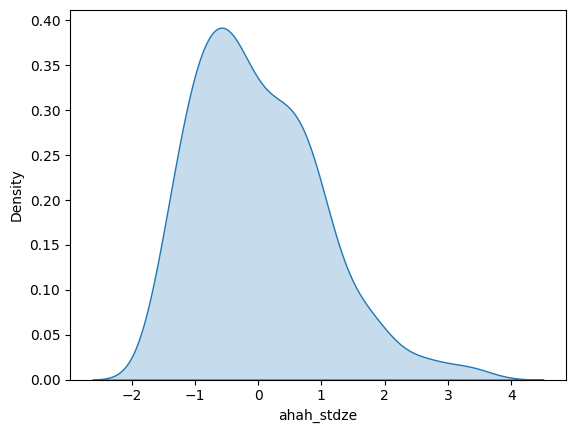

In [9]:
#Note that by doing this, the "ahah_stdze" variable should follow approximately a N(0,1) distribution
print(f"mu = {round(ahah['ahah_stdze'].mean(), 1)}")
print(f"sigma = {round(ahah['ahah_stdze'].std(), 1)}")

sns.kdeplot(ahah['ahah_stdze'], fill=True)

### Create the spatial lag of the main AHAH score

In [10]:
ahah['w_ahah_stdze'] = weights.lag_spatial(w, ahah["ahah_stdze"])

In [11]:
#We'll check if the "w_ahah_stdze" is computed correctly with the example geometry

#the "w_ahah_stdze" for the example geometry using weights.lag_sapatial() function (pysal library)
w_ahah_example_geometry_pysal = ahah.loc[ahah['lsoa11cd'] == example_geometry_id, ['w_ahah_stdze']].values[0][0]

#the "w_ahah_stdze" for the example geometry computed "manually". 
#Recall that this is only the average (in this case simple average because we're using queen criteria) of the score for its neighbors
w_ahah_example_geometry_manual = ahah.loc[ahah['lsoa11cd'].isin(w.neighbors[example_geometry_id]), ['ahah_stdze']].mean()[0]

print(f"pysal: {w_ahah_example_geometry_pysal}")
print(f"manual: {w_ahah_example_geometry_manual}")

pysal: 1.0041009497394633
manual: 1.004100949739463


## Task II: global spatial autocorrelation

Let's move on to the analytics:

### Calculate Moran's I (with its p-value)

In [12]:
mi = esda.Moran(ahah['ahah'], w)

print(f"Moran's I: {mi.I}")
print(f"Moran's I (p_value): {mi.p_sim}")

Moran's I: 0.6770361378406533
Moran's I (p_value): 0.001


In [13]:
#Note that it doesn't matter if you use the standardize version of the variable. Moran's I will be the same.
#We only standardize the metric for visualization purposes

mi_stdze = esda.Moran(ahah['ahah_stdze'], w)

print(f"Moran's I : {mi_stdze.I}")
print(f"Moran's I (p_value): {mi_stdze.p_sim}")

Moran's I : 0.6770361378406532
Moran's I (p_value): 0.001


### Visualise the main AHAH score with a Moran Plot

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Scatterplot (0.68)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

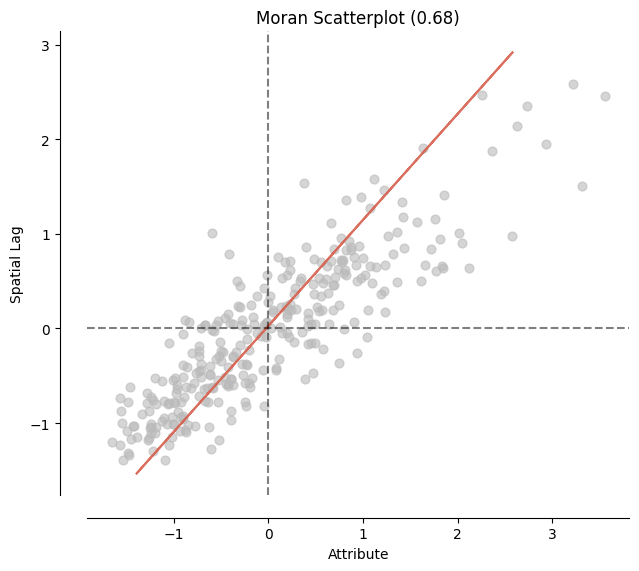

In [14]:
#Note that "mi" object was defined without the standardize version of "ahah", but the function does the job for us ;)
moran_scatterplot(mi)

### *What conclusions can you reach from the Moran Plot and Moran's I? What's the main spatial pattern?*

#### Answer the question here:

There is a positive and relatively strong (0.68) spatial autocorrelation. That indicates that, globally speaking, high values of AHAH index are surrounded by high values of AHAH index, and viceversa. The metric is "consistent" over space.

## Task III: local spatial autocorrelation

Now that you have a good sense of the overall pattern in the AHAH dataset, let's move to the local scale:

### Calculate LISA statistics for the LSOA areas


In [15]:
lisa = esda.Moran_Local(ahah['ahah'], w)

### Make a map of significant clusters at the 5%

(<Figure size 640x480 with 1 Axes>, <Axes: >)

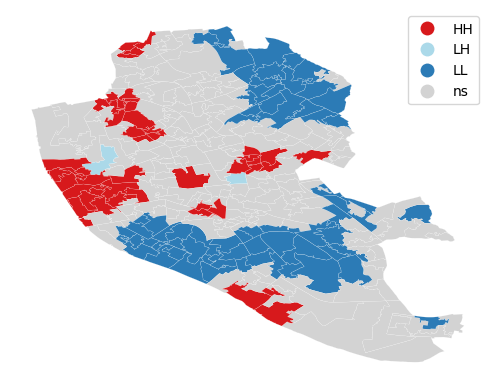

In [16]:
lisa_cluster(lisa, ahah, p=0.05)

### Compute the numbers of LSOAS for each cluster

Remember that when the LSOAS are not significant (p-value above threshold), the cluster should be "ns" (same as the previous plot)

In [17]:
#First, we get the quadrant and significance from "lisa" object
ahah['significant'] = lisa.p_sim < 0.05
ahah['quadrant'] = lisa.q

#We can get the label for each LSOAS using a mapping from the quadrant number to the label
lisa_mapping = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
ahah['lisa_quadrant_label'] = ahah['quadrant'].apply(lambda x: lisa_mapping[x])

#Now, we set the label "ns" to all the not significant quadrants
ahah['lisa_quadrant_label'] = np.where(ahah['significant'], ahah['lisa_quadrant_label'], 'ns')

#Now we count how many LSOAS are for each label
print(ahah['lisa_quadrant_label'].value_counts())

#(this is how the dataset looks like at the end with the columns we've created)
ahah[['lsoa11cd', 'ahah', 'quadrant', 'significant', 'lisa_quadrant_label']].head()

lisa_quadrant_label
ns    182
LL     66
HH     48
LH      2
Name: count, dtype: int64


,lsoa11cd,ahah,quadrant,significant,lisa_quadrant_label
0,E01006512,26.870382,1,True,HH
1,E01006513,46.542967,1,True,HH
2,E01006514,38.256588,1,True,HH
3,E01006515,27.819724,1,True,HH
4,E01006518,28.315099,1,False,ns


### *Can you identify hotspots or coldspots? If so, what do they mean? What about spatial outliers?*

#### Answer the question here:

Yes. There are 48 hotspots (red areas in the LISA map), 66 coldspots (blue areas in LISA map) and 2 spatial outliers (LH, ligh blue in LISA map).

In this case, hotspots (coldspots) indicate neighborhoods with high (low) AHAH index surrounded by neighborhoods with high (low) AHAH index as well. This is the majority of the neighbors identified as significant (98%) confirming the global pattern from Moran's plot.

The spatial outliers (Low-High) are neighborhoods that have a low AHAH index, surrounded by neighborhoods with high AHAH index. By definition, these neighborhoods are close to the hotspots. Probably these are the sububurs of the hotspots

### Create cluster maps for significance levels 1% and 10%; compare them with the one we obtained before. *What are the main changes? Why?*


**Hint:** the function `lisa_cluster` has a parameter `p` to adjust the p-value threshold for significance. Check the [docs](https://splot.readthedocs.io/en/latest/generated/splot.esda.lisa_cluster.html) as a reference.

#### 1%

lisa_quadrant_label
ns    235
LL     42
HH     20
LH      1
Name: count, dtype: int64


(<Figure size 640x480 with 1 Axes>, <Axes: >)

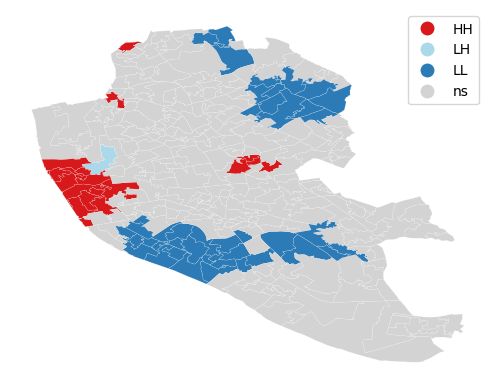

In [19]:
#Note that we don't have to create the "lisa" object again since it doesn't take the significance level as input.
# Thus, we only need to redefine the "significant" column
pvalue_threshold = 0.01
ahah['significant'] = lisa.p_sim < pvalue_threshold

#The label changes because "significant" have changed
ahah['lisa_quadrant_label'] = ahah['quadrant'].apply(lambda x: lisa_mapping[x])
ahah['lisa_quadrant_label'] = np.where(ahah['significant'], ahah['lisa_quadrant_label'], 'ns')

print(ahah['lisa_quadrant_label'].value_counts())

lisa_cluster(lisa, ahah, p=pvalue_threshold)

#### 10%

lisa_quadrant_label
ns    140
LL     88
HH     66
LH      4
Name: count, dtype: int64


(<Figure size 640x480 with 1 Axes>, <Axes: >)

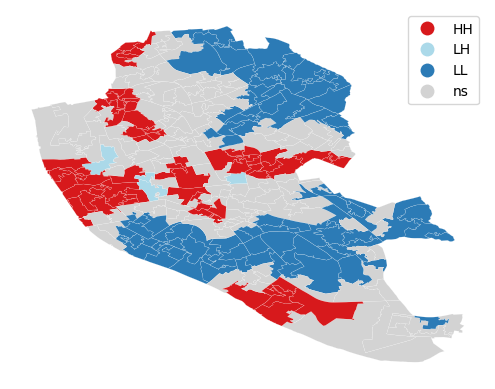

In [20]:
pvalue_threshold = 0.1
ahah['significant'] = lisa.p_sim < pvalue_threshold

#The label changes because "significant" have changed
ahah['lisa_quadrant_label'] = ahah['quadrant'].apply(lambda x: lisa_mapping[x])
ahah['lisa_quadrant_label'] = np.where(ahah['significant'], ahah['lisa_quadrant_label'], 'ns')

print(ahah['lisa_quadrant_label'].value_counts())

lisa_cluster(lisa, ahah, p=pvalue_threshold)

#### Answer the question here:

Same interpretation of LISA quadrants apply as before. However in this case the effect of the p-value allows more (less) neighborhoods to be considered as significants. 

A lower p-value is a stricter threshold and thus, compared with the baseline (p-value=5%), fewer neighborhoods are considered as significants (more geometries are colored in gray "ns" in LISA map). However, a lower p-value implies a higher confidence in the quadrant assigned to the neighborhood. The interpretation for a higher p-value is exactly the other way around. 

Note that in this case, when going from 5% to 1% (182 vs 235 "ns"), 53 neighborhoods are now considered as "ns" while when going from 5% to 10% (182 vs 140 "ns"), 40 neighborhoods are now considered as significant. 